In [ ]:
import sys
import os


sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))


from parton_splittings import *

In [ ]:
fit = simple_fitter().to(device)

trainable_params = sum(p.numel() for p in fit.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")

#Define NN criteria and optmizer
criterion = nn.MSELoss()
optimizer = optim.Adam(fit.parameters(), lr=0.01, weight_decay=1e-6)  

Total trainable parameters: 58242


In [ ]:
#THIS IS STILL BEING DONE MANUALLY. SETTING UP THE SYSTEM AGAIN...

sis = phsys(100, 0.3, 1.5, 1.5) #E, z, qF, Medium size (grid)
sis.set_dim(32,32,32,32)
f_sol = np.load("saved_files/fsol_t=1.845_E=100.0GeV_q=1.5_z=0.3.npy")
sis.set_fsol(f_sol)
sis.set_t(1.845)



In [4]:
X_dom = []
for i1 in range(sis.Nu1):
    for i2 in range(sis.Nu2):
        for j1 in range(sis.Nv1):
            for j2 in range(sis.Nv2):
                X_dom.append([sis.U1[i1], sis.U2[i2], sis.V1[j1], sis.V2[j2]])



In [7]:
x_dom_torch = torch.tensor(X_dom, dtype=torch.float32).to(device) #Export domain as a torch tensor

epochs = 1000
f_sol_torch_re = torch.tensor(np.real(sis.Fsol[1]).reshape(-1, 1), dtype=torch.float32).to(device)
f_sol_torch_im = torch.tensor(np.imag(sis.Fsol[1]).reshape(-1, 1), dtype=torch.float32).to(device)
f_sol_torch = torch.cat([f_sol_torch_re, f_sol_torch_im], dim = 1)

batch_size = x_dom_torch.size(0)  # Adjust based on available memory
num_samples = x_dom_torch.size(0)
accumulation_steps = 4  # Number of mini-batches to accumulate gradients



for epoch in range(epochs):
    indices = torch.randperm(num_samples, device=device)
    epoch_loss = 0.0
    optimizer.zero_grad()
    
    for i in range(0, num_samples, batch_size):

        batch_indices = indices[i:i + batch_size]
        batch_x = x_dom_torch[batch_indices]
        batch_y = f_sol_torch[batch_indices]
        
        # Forward pass
        y_pred = fit(batch_x)
        loss = criterion(y_pred, batch_y)
        loss = loss / accumulation_steps  # Normalize loss to account for accumulation
        
        # Backward pass (accumulate gradients)
        loss.backward()
        epoch_loss += loss.item() * accumulation_steps  # Multiply back to original loss
        
        # Step optimizer after accumulation_steps mini-batches
        if ((i // batch_size) + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    optimizer.step()
    optimizer.zero_grad()

    if epoch%100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')





Epoch 0, Loss: 6322752.5
Epoch 100, Loss: 6075952.0
Epoch 200, Loss: 6014395.5
Epoch 300, Loss: 5617152.5
Epoch 400, Loss: 5428884.0
Epoch 500, Loss: 5252969.0
Epoch 600, Loss: 4989018.0
Epoch 700, Loss: 4779345.0
Epoch 800, Loss: 4671032.5
Epoch 900, Loss: 4434602.0


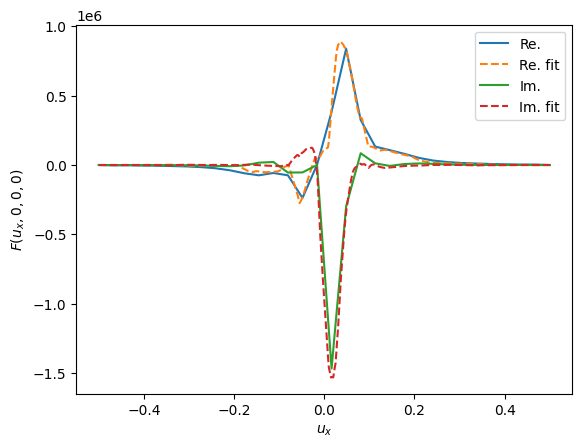

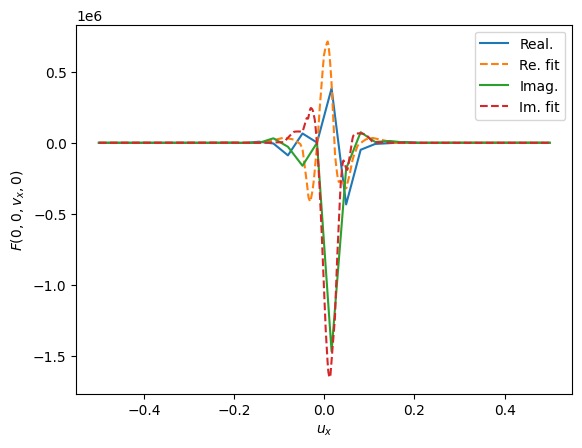

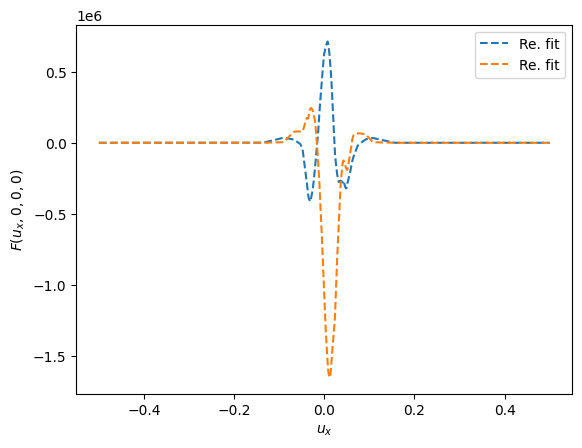

In [8]:
##PLOT TEST to FIT
U1_new = np.linspace(-sis.L/2, sis.L/2, 2048)
fit_test_re_u1 = .0 * U1_new 
fit_test_im_u1 = .0 * U1_new 

fit_test_re_v1 = .0 * U1_new 
fit_test_im_v1 = .0 * U1_new 

for l in range(len(U1_new)):
    fit_test_re_u1[l] = fit(torch.tensor([U1_new[l], sis.U2[sis.Nu2//2], sis.V1[sis.Nv1//2], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[0]

    fit_test_im_u1[l] = fit(torch.tensor([U1_new[l], sis.U2[sis.Nu2//2], sis.V1[sis.Nv1//2], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[1]

    fit_test_re_v1[l] = fit(torch.tensor([sis.U1[sis.Nu1//2], sis.U2[sis.Nu2//2], U1_new[l], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[0]

    fit_test_im_v1[l] = fit(torch.tensor([sis.U1[sis.Nu1//2], sis.U2[sis.Nu2//2], U1_new[l], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[1]



plt.plot(sis.U1, np.real(sis.Fsol[1, :, sis.Nu2//2, sis.Nv1//2, sis.Nv2//2]), label = "Re.")
plt.plot(U1_new, fit_test_re_u1, "--", label = "Re. fit")
plt.plot(sis.U1, np.imag(sis.Fsol[1, :, sis.Nu2//2, sis.Nv1//2, sis.Nv2//2]), label = "Im.")
plt.plot(U1_new, fit_test_im_u1, "--", label = "Im. fit")
plt.xlabel("$u_x$")
plt.ylabel("$F(u_x, 0, 0, 0)$")
plt.legend()
plt.show()

plt.plot(sis.V1, np.real(sis.Fsol[1,  sis.Nu1//2,  sis.Nu2//2, :, sis.Nv2//2 ]), label = "Real.")
plt.plot(U1_new, fit_test_re_v1, "--", label = "Re. fit")
plt.plot(sis.V1, np.imag(sis.Fsol[1, sis.Nu1//2,  sis.Nu2//2, :,  sis.Nv2//2 ]), label = "Imag.")
plt.plot(U1_new, fit_test_im_v1, "--", label = "Im. fit")
plt.xlabel("$u_x$")
plt.ylabel("$F(0, 0, v_x, 0)$")
plt.legend()
plt.show()


plt.plot(U1_new, fit_test_re_v1, "--", label = "Re. fit")
plt.plot(U1_new, fit_test_im_v1, "--", label = "Re. fit")

plt.xlabel("$u_x$")
plt.ylabel("$F(u_x, 0, 0, 0)$")
plt.legend()
plt.show()

In [9]:
torch.save(fit, "saved_fits/fit_example.pth")